In [1]:
#!usr/bin/python3

import nltk
from nltk.corpus import stopwords
import speech as sp
import pandas as pd
import matplotlib.pyplot as plt
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.classify import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm, metrics
from sklearn.svm import SVC
from textblob import TextBlob

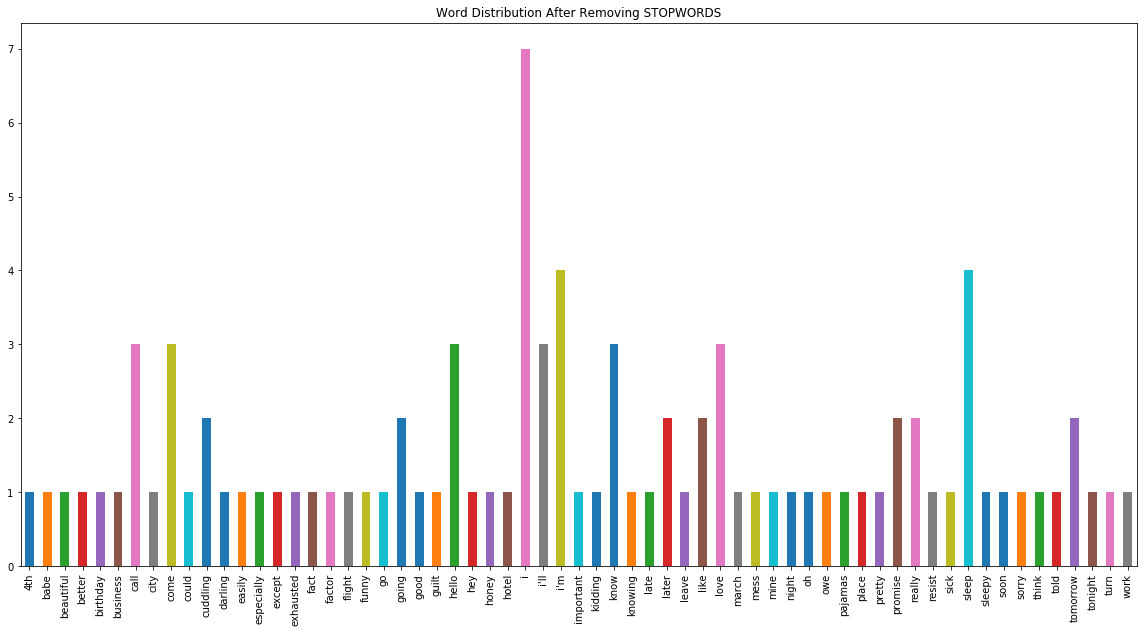

In [2]:
#nltk.download() #Run this step if you do not have the NLTK packages. 

#Removing STOP Words
stop_words = stopwords.words('english')
tokens = [ j for i in sp.transcript_strings for j in i.split()]

clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)

word_matcher = {}
def transcript_word_analysis2():
    for j in clean_tokens:
            j = j.lower()
            if j in word_matcher:
                word_matcher[j]+=1
            else:
                word_matcher[j]=1

    word_series = pd.Series(word_matcher,name="Word Counter")
    word_series.plot(kind="bar",figsize = (20,10))
    plt.title("Word Distribution After Removing STOPWORDS")
    plt.show()
transcript_word_analysis2()

In [3]:

def get_phrase_sentiment(phrase):
    analysis = TextBlob(phrase)
    if analysis.sentiment.polarity > 0:
        return 'positive', float(format(analysis.sentiment.polarity, '.3f'))
    elif analysis.sentiment.polarity == 0:
        return 'neutral', float(format(analysis.sentiment.polarity, '.3f'))
    else:
        return 'negative', float(format(analysis.sentiment.polarity, '.3f'))

transcript_str_string = " ".join(list(word_matcher))
string_list = transcript_str_string.split()
st_dict = {}
for i in string_list:
    if not i[-1].isalpha():
        i = i[:-1]
    st_dict[i] = get_phrase_sentiment(i)


df = pd.DataFrame.from_dict(st_dict,orient="index")
df.reset_index()
df.columns = ["polarity_nature","polarity_value"]
print(df.head())

      polarity_nature  polarity_value
sorry        negative            -0.5
fact          neutral             0.0
city          neutral             0.0
think         neutral             0.0
night         neutral             0.0


In [4]:
def new_column(j):
    if j in ["neutral","positive"]:
        return ({"fair":j},1)
    else:
        return ({"unfair":j},0)
df["status"] = df.polarity_nature.apply(new_column)
my_list = df["status"].values

neg_features = []
pos_features = []
for k in my_list:
    if list(k[0])=="fair":
        pos_features.append(k)
    else:
        neg_features.append(k)

negcutoff = len(neg_features)*3//4
poscutoff = len(pos_features)*3//4
trainfeats = neg_features[:negcutoff] + pos_features[:poscutoff]
testfeats = neg_features[negcutoff:] + pos_features[poscutoff:]
print('Total Training Instances - '+ str(len(trainfeats)))
print( 'Total Testing Instances - ' + str(len(testfeats)))

Total Training Instances - 47
Total Testing Instances - 16


In [5]:

classifier = NaiveBayesClassifier.train(trainfeats)
print('NLTK NaiveBayesClassifier accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

NLTK NaiveBayesClassifier accuracy: 1.0


In [6]:
classifier1 = DecisionTreeClassifier.train(trainfeats,entropy_cutoff=0)
print('DecisionTreeClassifier accuracy:', nltk.classify.util.accuracy(classifier1, testfeats))

DecisionTreeClassifier accuracy: 1.0


In [7]:
feature_names = ["polarity_nature","polarity_value"]
X = df[feature_names]
X.polarity_nature = X.polarity_nature.apply(lambda i: 0.0 if i=="neutral" else ( 1.0 if i=="postive" else -1.0))
df["status1"] = df.status.apply(lambda i: 0.0 if i==({u'fair': u'neutral'}, 1) else ( 1.0 if i==({u'fair': u'positive'}, 1) else -1.0))
y = df.status1
print (y.head())

sorry   -1.0
fact     0.0
city     0.0
think    0.0
night    0.0
Name: status1, dtype: float64


/home/osboxes/.local/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.2)
print ('The Training Samples are - ', len(X_train))
print('The Testing Samples are - ', len(X_test))

The Training Samples are -  50
The Testing Samples are -  13


In [9]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print ("Linear Regression Accuracy -", metrics.accuracy_score(y_test, y_pred.round()))

Linear Regression Accuracy - 0.8461538461538461


In [10]:
clf = svm.SVC()
clf.fit(X_train, y_train)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
y_pred1 = clf.predict(X_test)

print ("SVC Accuracy -", metrics.accuracy_score(y_test, y_pred1.round()))

if __name__ == "__main__":
	pass

SVC Accuracy - 1.0
